In [199]:
# import stuff
import gpxpy.gpx
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm

# constants
GPX_FILE = '/Users/garrett/workspace/vertpro/tildenhalfv3.gpx'
METERS_TO_FEET = 3.28084
METERS_TO_MILES = 0.000621371

# these are course points (in miles) where garmin pacepro suggests a change in pace
# the points are based on changes in the elevation profile of the course
# the points are useful, but pacepro doesn't give good pacing strategies for courses with a lot of vert
# instead, we'll use the splits but calculate our own pace for each split based on the elevation profile
PACE_CHANGE_SPLITS = np.array([0,0.64,0.89,1.46,1.80,2.05,2.51,2.97,3.22,3.56,4.08,4.54,4.90,5.31,5.61,6.46,6.72,7.14,7.63,7.88,8.19,8.44,8.69,9.02,9.53,9.94,10.26,10.74,11.10,12.00,12.48,13.19,13.44,])
PACE_CHANGE_SPLITS_MILES = np.array([x for x in range(0, 14)] + [13.41])
KM_TO_MI = 0.621371
PACE_CHANGE_SPLITS_KM = np.array([x * KM_TO_MI for x in range(0, 22)] + [13.41])


In [200]:
# use the haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

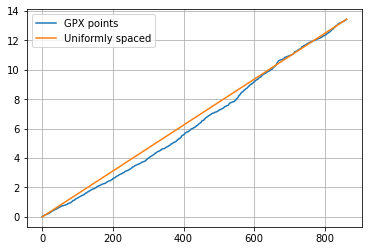

In [201]:
# load course gpx file
with open(GPX_FILE, 'r') as f:
    gpx = gpxpy.parse(f)

# calculate the distance in miles at each point
distance_in_miles = [0]
for i in range(1, len(gpx.tracks[0].segments[0].points)):
    lat1 = gpx.tracks[0].segments[0].points[i-1].latitude
    lon1 = gpx.tracks[0].segments[0].points[i-1].longitude
    lat2 = gpx.tracks[0].segments[0].points[i].latitude
    lon2 = gpx.tracks[0].segments[0].points[i].longitude
    distance_in_miles.append(distance_in_miles[-1] + haversine(lat1, lon1, lat2, lon2))
distance_in_miles = np.array(distance_in_miles)

# the points aren't uniformly spaced distance-wise, but it's pretty close
plt.plot(distance_in_miles, label='GPX points')
plt.plot(np.linspace(0, distance_in_miles[-1], len(distance_in_miles)), label='Uniformly spaced')
plt.grid()
plt.legend()
plt.show()

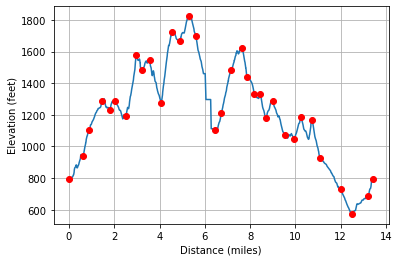

In [202]:
# calculate elevation data
elevation_in_meters = np.array([point.elevation for point in gpx.tracks[0].segments[0].points])
elevation_in_feet = elevation_in_meters * METERS_TO_FEET
elevation_in_miles = elevation_in_meters * METERS_TO_MILES
elevation_in_miles = elevation_in_feet / 5280

# plot the course elevation profile
plt.plot(distance_in_miles, elevation_in_feet)
plt.xlabel('Distance (miles)')
plt.ylabel('Elevation (feet)')
plt.grid()

# add red dots at the suggested pace change points
for split in PACE_CHANGE_SPLITS:
    plt.plot(split, elevation_in_feet[np.argmin(np.abs(distance_in_miles - split))], 'ro')

plt.show()

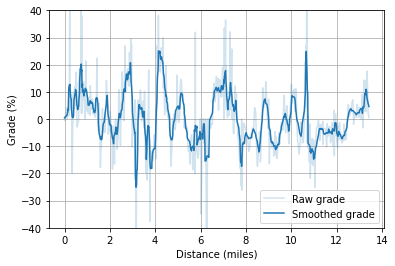

In [203]:
# calculate the grade at each point
raw_grade = np.gradient(elevation_in_miles, distance_in_miles) * 100
# smooth the grade to reduce extreme values
window = 10
smooth_grade = np.convolve(raw_grade, np.ones(window)/window, mode='same')

# plot the grade profile
plt.plot(distance_in_miles, raw_grade, label='Raw grade', alpha=0.2, c='C0')
plt.plot(distance_in_miles, smooth_grade, label='Smoothed grade', c='C0')
plt.xlabel('Distance (miles)')
plt.ylabel('Grade (%)')
plt.ylim(-40, 40)
plt.grid()
plt.legend()
plt.show()


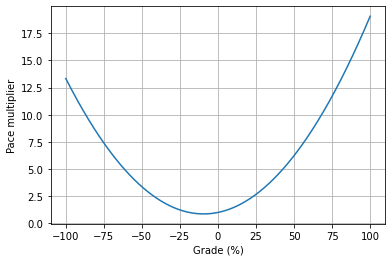

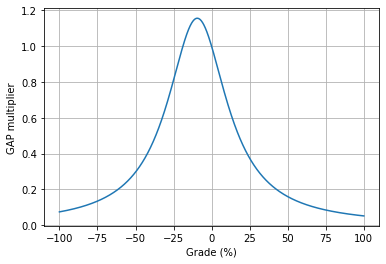

In [204]:
def grade_adjusted_pace_multiplier(grade):
    """
    Given a grade, return the coefficient by which a flat pace must be multiplied by
    to estimate the hill pace at equal heart rate.
    The formula is from:
    https://www.reddit.com/r/Strava/comments/sdeix0/mind_the_gap_getting_fit_for_the_formula_equation/
    """
    return 1 + 0.02869556 * grade + 0.001520768 * grade ** 2

def pace_to_gap(pace, grade):
    """
    Given a pace and grade, return the GAP
    """
    return pace / grade_adjusted_pace_multiplier(grade)

def gap_to_pace(gap, grade):
    """
    Given a GAP and grade, return the pace
    """
    return gap * grade_adjusted_pace_multiplier(grade)

# uphill is harder and downhill is easier, but super steep downhill is also hard
xvals = np.linspace(-100, 100, 1000)
yvals = grade_adjusted_pace_multiplier(xvals)
plt.plot(xvals, yvals)
plt.xlabel('Grade (%)')
plt.ylabel('Pace multiplier')
plt.grid()
plt.show()

# the other way around is more informative:
# given a goal GAP, how much faster/slower should we be running uphill/downhill?
plt.plot(xvals, 1/yvals)
plt.xlabel('Grade (%)')
plt.ylabel('GAP multiplier')
plt.grid()



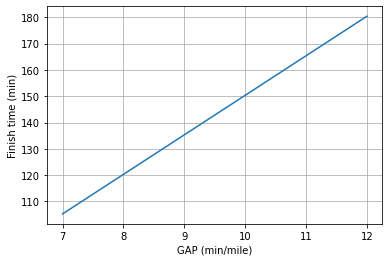

In [205]:
# see how GAP affects finishing time
gap_options = np.linspace(7, 12, 1000)
finish_time = []
for gap in gap_options:
    pace = gap_to_pace(gap, smooth_grade)
    finish_time.append(np.sum(pace * np.gradient(distance_in_miles)))

plt.plot(gap_options, finish_time)
plt.xlabel('GAP (min/mile)')
plt.ylabel('Finish time (min)')
plt.grid()
plt.show()


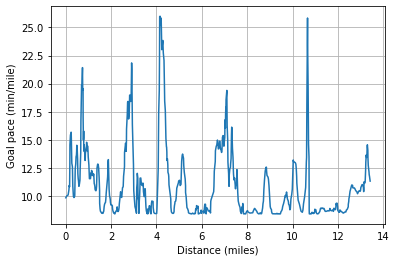

In [209]:
# build a racing strategy
goal_gap = 9 + 43/60
goal_pace = gap_to_pace(goal_gap, smooth_grade)

# the goal pace is noisy, but we'll map it to segments of the course where elevation changes
plt.plot(distance_in_miles, goal_pace)
plt.xlabel('Distance (miles)')
plt.ylabel('Goal pace (min/mile)')
plt.grid()
plt.show()


In [210]:
time_spent_in_split = []
for split_start, split_end in zip(PACE_CHANGE_SPLITS[:-1], PACE_CHANGE_SPLITS[1:]):
    # find the points in the GPX data that correspond to the start and end of this split
    start_index = np.argmin(np.abs(distance_in_miles - split_start))
    end_index = np.argmin(np.abs(distance_in_miles - split_end))
    # calculate the time spent in this split
    time_spent_in_split.append(np.sum(goal_pace[start_index:end_index] * np.gradient(distance_in_miles[start_index:end_index])))

pace_by_split = np.array(time_spent_in_split) / (PACE_CHANGE_SPLITS[1:] - PACE_CHANGE_SPLITS[:-1])
slowest_pace = np.max(pace_by_split)
fastest_pace = np.min(pace_by_split)
total_time = np.sum(time_spent_in_split)


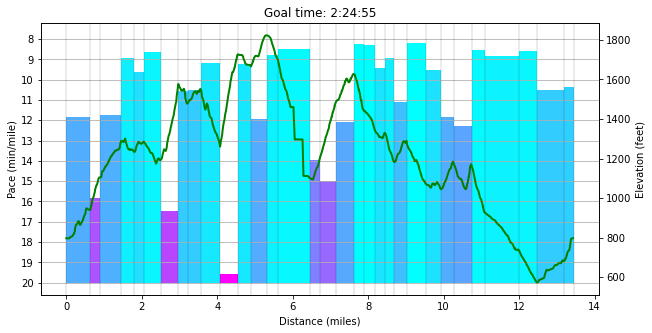

In [211]:
# plot the final strategy!
plt.figure(figsize=(10, 5))

# add a bar graph of the pace for each split, where the splits are color coded by pace
cmap = plt.get_cmap('cool')
norm = plt.Normalize(vmin=pace_by_split.min(), vmax=pace_by_split.max())
colors = [cmap(norm(value)) for value in pace_by_split]
bar_widths = (PACE_CHANGE_SPLITS[1:] - PACE_CHANGE_SPLITS[:-1]) - 0.0
# plot 20 - pace_by_split because we want the bars to be taller for faster paces
plt.bar(PACE_CHANGE_SPLITS[:-1], 20-pace_by_split, width=bar_widths, align='edge', bottom=0, color=colors)
# adjust y axis labels to show the correct pace
plt.yticks(np.arange(0, 20, 1), np.arange(20, 0, -1))
plt.xlabel('Distance (miles)')
plt.ylabel('Pace (min/mile)')
plt.ylim(20-slowest_pace-1, 20-fastest_pace+1)
plt.grid(axis='y')

# add vertical lines at the start of each split
for split in PACE_CHANGE_SPLITS:
    plt.axvline(split, c='k', alpha=0.1)

# elevation profile
plt.twinx()
plt.plot(distance_in_miles, elevation_in_feet, color='green', linewidth=2)
plt.xlabel('Distance (miles)')
plt.ylabel('Elevation (feet)')

plt.title('Goal time: {}:{}:{}'.format(int(total_time//60), int(total_time%60), int((total_time%1)*60)))
plt.show()


In [212]:
# print the splits
# for split_start, split_end, pace in zip(PACE_CHANGE_SPLITS[:-1], PACE_CHANGE_SPLITS[1:], pace_by_split):
    # print('Split {}-{}: {}:{}:{}'.format(split_start, split_end, int(pace//60), int(pace%60), int((pace%1)*60)))


In [213]:
"""Some functions for parsing a GPX file (specifically, a GPX file
downloaded from Strava, which was generated based on data recorded by a
Garmin vívoactive 3) and creating a Pandas DataFrame with the data.
"""

from typing import Dict, Union
from datetime import datetime

import gpxpy
import pandas as pd


# The XML namespaces used by the GPX file for extensions, used when parsing the extensions
NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}

# The names of the columns we will use in our DataFrame
COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time', 'heart_rate', 'cadence']

def get_gpx_point_data(point: gpxpy.gpx.GPXTrackPoint) -> Dict[str, Union[float, datetime, int]]:
        """Return a tuple containing some key data about `point`."""
        
        data = {
            'latitude': point.latitude,
            'longitude': point.longitude,
            'elevation': point.elevation,
            'time': point.time
        }
    
        # Parse extensions for heart rate and cadence data, if available
        elem = point.extensions[0]  # Assuming we know there is only one extension
        # print(elem)
        try:
            data['heart_rate'] = int(elem.find('garmin_tpe:hr', NAMESPACES).text)
        except AttributeError:
            # "text" attribute not found, so data not available
            pass
            
        try:
            data['cadence'] = int(elem.find('garmin_tpe:cad', NAMESPACES).text)
        except AttributeError:
            pass

        return data

def get_dataframe_from_gpx(fname: str) -> pd.DataFrame:
    """Takes the path to a GPX file (as a string) and returns a Pandas
    DataFrame.
    """
    with open(fname) as f:
        gpx = gpxpy.parse(f)
    segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
    data = [get_gpx_point_data(point) for point in segment.points]
    return pd.DataFrame(data, columns=COLUMN_NAMES)


In [214]:
RUNS_DIR = '/Users/garrett/workspace/vertpro/2022 trail runs'

heart_rates_bpm = []
grades_pct = []
paces_min_per_mile = []

for fname in tqdm(os.listdir(RUNS_DIR)):
    if not fname.endswith('.gpx'):
        continue
    df = get_dataframe_from_gpx(os.path.join(RUNS_DIR, fname))

    # catch the numpy warning if we divide by zero
    with np.errstate(divide='raise', invalid='raise'):
        try:
            dist_in_miles = [0]
            for i in range(1, len(df)):
                dist_in_miles.append(dist_in_miles[-1] + haversine(df['latitude'][i-1], df['longitude'][i-1], df['latitude'][i], df['longitude'][i]))

            elevation_in_miles = df['elevation'].values * 3.28084 / 5280
            raw_grade = np.gradient(elevation_in_miles, dist_in_miles) * 100

            time_in_minutes = (df['time'] - df['time'][0]).dt.total_seconds() / 60
            # if there is a big jump in time, assume the watch was paused
            time_diff = np.diff(time_in_minutes)
            time_diff[time_diff > 5/60] = 0
            time_in_minutes = np.cumsum(time_diff)
            time_in_minutes = np.insert(time_in_minutes, 0, 0)
            pace_in_minutes_per_mile = np.gradient(time_in_minutes, dist_in_miles)
            
        except FloatingPointError:
            continue

    window = 7
    smooth_grade = np.convolve(raw_grade, np.ones(window)/window, mode='same')
    smooth_heart_rate = np.convolve(df['heart_rate'].values, np.ones(window)/window, mode='same')
    smooth_pace = np.convolve(pace_in_minutes_per_mile, np.ones(window)/window, mode='same')

    heart_rates_bpm.extend(smooth_heart_rate)
    grades_pct.extend(smooth_grade)
    paces_min_per_mile.extend(smooth_pace)

heart_rates_bpm = np.array(heart_rates_bpm)
grades_pct = np.array(grades_pct)
paces_min_per_mile = np.array(paces_min_per_mile)


100%|██████████| 96/96 [00:21<00:00,  4.49it/s]


In [215]:

# if the grade is very close to zero even after smoothing, filter it out
bad_idx = np.abs(grades_pct) < 1e-6
grades_pct = np.delete(grades_pct, bad_idx)
heart_rates_bpm = np.delete(heart_rates_bpm, bad_idx)
paces_min_per_mile = np.delete(paces_min_per_mile, bad_idx)

# filter out nan entries
bad_idx = np.isnan(paces_min_per_mile)
bad_idx = np.logical_or(bad_idx, np.isnan(heart_rates_bpm))
bad_idx = np.logical_or(bad_idx, np.isnan(grades_pct))
grades_pct = np.delete(grades_pct, bad_idx)
heart_rates_bpm = np.delete(heart_rates_bpm, bad_idx)
paces_min_per_mile = np.delete(paces_min_per_mile, bad_idx)



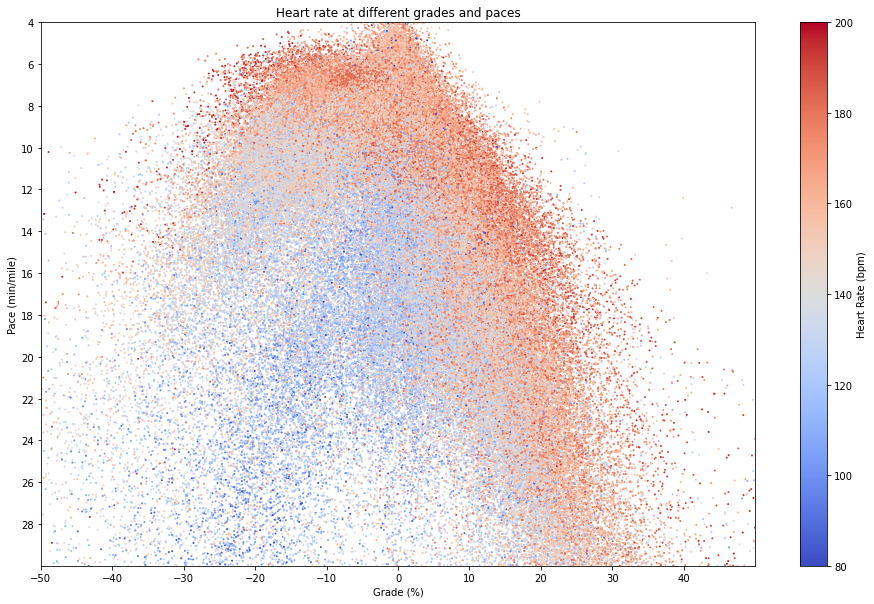

In [218]:
# create a scatter plot of pace vs. grade colored by heart rate from blue (low) to red (high)
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=80, vmax=200)
plt.figure(figsize=(16, 10))
plt.scatter(grades_pct, paces_min_per_mile, color=cmap(norm(heart_rates_bpm)), s=1, alpha=1)
plt.xlabel('Grade (%)')
plt.ylabel('Pace (min/mile)')
plt.title('Heart rate at different grades and paces')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Heart Rate (bpm)')
plt.xlim(-50, 50)
plt.ylim(4, 30)
# flip the y axis so that the fastest paces are at the top
plt.gca().invert_yaxis()
plt.xticks(np.arange(-50, 50, 10))
plt.yticks(np.arange(4, 30, 2))
plt.show()


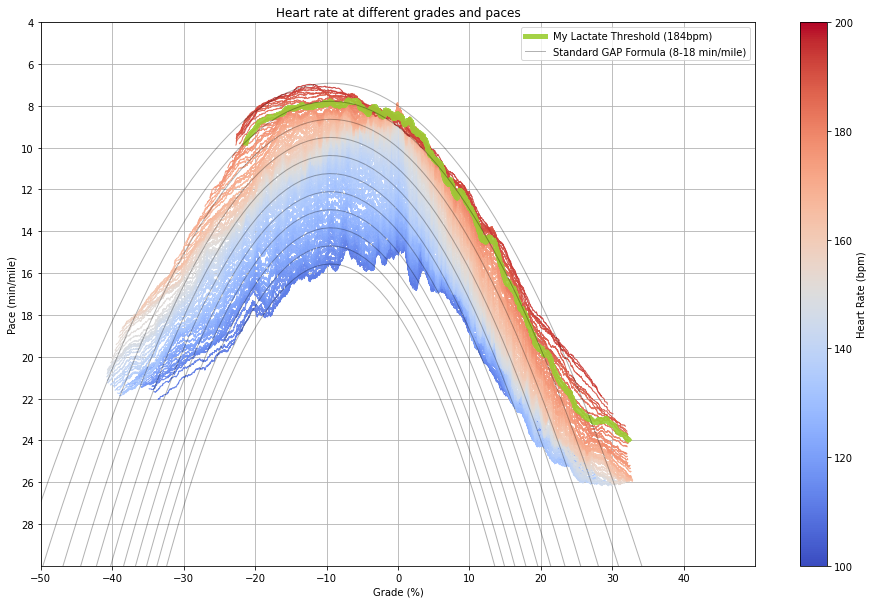

In [217]:
plt.figure(figsize=(16, 10))
# plt.scatter(grades_pct, paces_min_per_mile, color=cmap(norm(heart_rates_bpm)), s=1, alpha=0.1)
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=100, vmax=200)
# look at heart rate ranges 
last_plot = False
for hrmin, hrmax in zip(list(range(100, 185, 1)) + [174], list(range(120, 205, 1)) + [194]):
    idx = np.logical_and(heart_rates_bpm >= hrmin, heart_rates_bpm < hrmax)
        
    grades_at_hr = grades_pct[idx]
    paces_at_hr = paces_min_per_mile[idx]
    hr_at_hr = heart_rates_bpm[idx]

    # only consider grades between -50 to 50 and paces between 4 and 30
    idx = np.where(np.abs(grades_at_hr) < 50)
    idx = np.intersect1d(idx, np.where(paces_at_hr > 4))
    idx = np.intersect1d(idx, np.where(paces_at_hr < 30))

    grades_at_hr = grades_at_hr[idx]
    paces_at_hr = paces_at_hr[idx]
    hr_at_hr = hr_at_hr[idx]

    # solve for the best fit polynomial of degree 2
    p = np.polyfit(grades_at_hr, paces_at_hr, 2)

    # sort by grades
    idx = np.argsort(grades_at_hr)
    grades_at_hr = grades_at_hr[idx]
    paces_at_hr = paces_at_hr[idx]
    hr_at_hr = hr_at_hr[idx]

    # use a sliding window average to smooth the data
    # convolve the data with a gaussian
    window_size = 500
    window_lim = 5
    stddev = 10
    gaussian_filter = np.exp(-np.linspace(-window_lim, window_lim, window_size)**2 / (2*stddev**2))
    gaussian_filter /= np.sum(gaussian_filter)
    smooth_paces = np.convolve(paces_at_hr, gaussian_filter, mode='valid')
    valid_xvals = grades_at_hr[window_size//2:-window_size//2+1]


    plt.xlabel('Grade (%)')
    plt.ylabel('Pace (min/mile)')
    plt.title('Heart rate at different grades and paces')
    # plt.colorbar(label='Heart Rate (bpm)')
    plt.xlim(-50, 50)
    plt.ylim(4, 30)
    # flip the y axis so that the fastest paces are at the top
    plt.gca().invert_yaxis()

    # plot the best fit polynomial
    x = np.linspace(-50, 50, 100)
    y = np.polyval(p, x)
    if hrmin == 174:
        if last_plot:
            plt.plot(valid_xvals, smooth_paces, linewidth=5, color='yellowgreen', alpha=0.9, label='My Lactate Threshold (184bpm)')
        else:
            last_plot = True
    else:
        plt.plot(valid_xvals, smooth_paces, linewidth=1, color=cmap(norm((hrmin + hrmax)/2)), alpha=0.9)

# add some gap curves to the plot
for gap in range(8, 19):
    x = np.linspace(-50, 50, 100)
    y = [gap_to_pace(gap, grade) for grade in x]
    if gap == 8:
        label = 'Standard GAP Formula (8-18 min/mile)'
    else:
        label = None
    plt.plot(x, y, linewidth=1, color='black', alpha=0.3, label=label)


plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Heart Rate (bpm)')
# make the plot have more x ticks and y ticks, and add a grid
plt.xticks(np.arange(-50, 50, 10))
plt.yticks(np.arange(4, 30, 2))
plt.grid()
plt.legend()
plt.show()
